In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics
from scipy.stats import norm
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import sklearn.model_selection as ms
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax,zscore
from sklearn.linear_model import ElasticNetCV, LassoCV, Lasso, ElasticNet, LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, RandomizedSearchCV 
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import linear_model
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from multiprocessing import cpu_count
from lightgbm import LGBMRegressor
%matplotlib inline

## Read Data

In [160]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
sample = pd.read_csv("sample_submission.csv")
print("Train:" + str(train.shape))
print("Test:" + str(test.shape))

Train:(1460, 80)
Test:(1459, 79)


In [161]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [162]:
train.shape

(1460, 80)

## Concatenate training and test features 

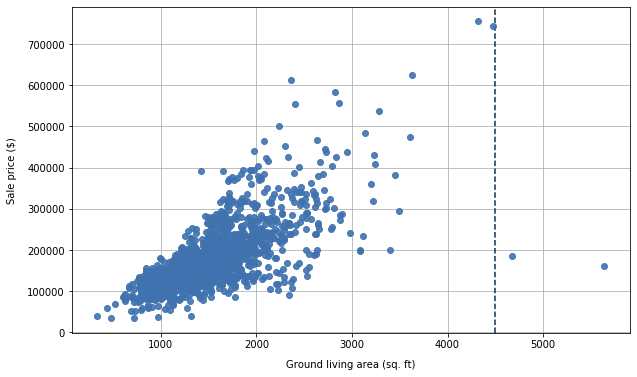

In [163]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.scatter(train["GrLivArea"], train["SalePrice"], c="#3f72af", zorder=3, alpha=0.9)
ax.axvline(4500, c="#112d4e", ls="--", zorder=2)
ax.set_xlabel("Ground living area (sq. ft)", labelpad=10)
ax.set_ylabel("Sale price ($)", labelpad=10)
plt.show()

In [164]:
train = train[train["GrLivArea"] < 4500]
X = pd.concat([train.drop("SalePrice", axis=1), test])

## Transform target variable

In [165]:
y_train = np.log(train["SalePrice"])

## SalePrice Distribution 

In [166]:
y = train.SalePrice 

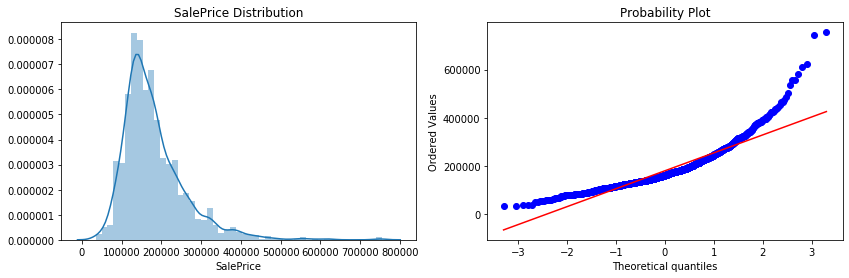

Skewness: 1.881296
Kurtosis: 6.523067


In [167]:
fig, (ax1, res) = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(y, ax = ax1)
ax1.set_title('SalePrice Distribution')
res = stats.probplot(y, plot=plt)
plt.show()
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

##  SalePrice Transformation 

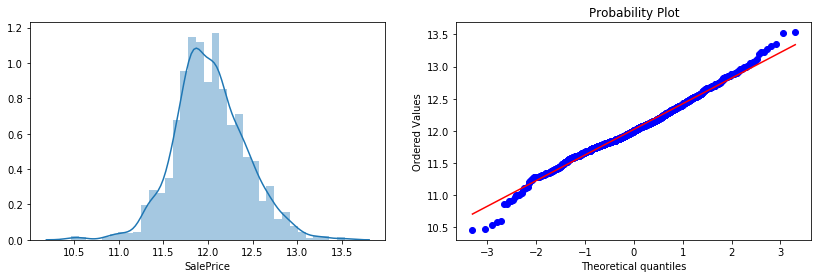

Skewness: 0.121568
Kurtosis: 0.804764


In [168]:
fig, (ax1, res) = plt.subplots(1, 2, figsize=(14,4))
sns.distplot(y_train, ax = ax1)
res = stats.probplot(y_train, plot=plt)
plt.show()

## after transformation Skewness, Kurtosis
print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt())

## Impute missing values

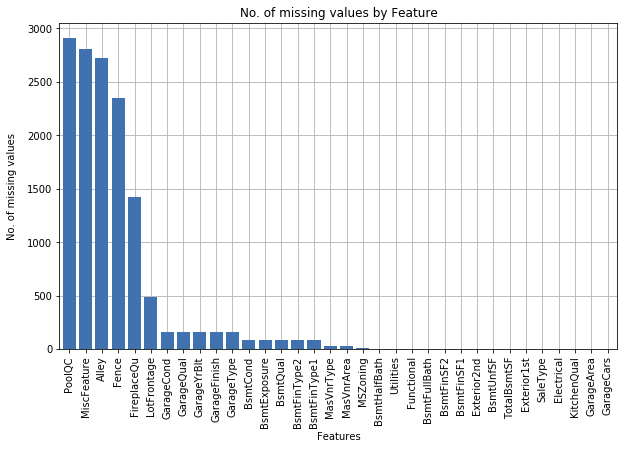

In [169]:
nans = X.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color="#3f72af")
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set(xlabel="Features")
ax.set(title="No. of missing values by Feature")
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)
plt.show()

In [170]:
cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageCond", "GarageQual", "GarageFinish", "GarageType", "BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1"]
X[cols] = X[cols].fillna("None")
cols = ["GarageYrBlt", "MasVnrArea", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "GarageCars"]
X[cols] = X[cols].fillna(0)
cols = ["MasVnrType", "MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "KitchenQual", "Functional"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.mode()[0]))
cols = ["GarageArea", "LotFrontage"]
X[cols] = X.groupby("Neighborhood")[cols].transform(lambda x: x.fillna(x.median()))

## Engineer features

In [171]:
X["TotalSF"] = X["GrLivArea"] + X["TotalBsmtSF"]
X["TotalPorchSF"] = X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]
X["TotalBath"] = X["FullBath"] + X["BsmtFullBath"] + 0.5 * (X["BsmtHalfBath"] + X["HalfBath"])

## Categorize MSSubClass and YrSold

In [172]:
cols = ["MSSubClass", "YrSold"]
X[cols] = X[cols].astype("category")

## Transform features

In [173]:
X["SinMoSold"] = np.sin(2 * np.pi * X["MoSold"] / 12)
X["CosMoSold"] = np.cos(2 * np.pi * X["MoSold"] / 12)
X = X.drop("MoSold", axis=1)

In [174]:
skew = X.skew(numeric_only=True).abs()
cols = skew[skew > 1].index
for col in cols:
    X[col] = boxcox1p(X[col], boxcox_normmax(X[col] + 1))

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [175]:
cols = X.select_dtypes(np.number).columns
X[cols] = RobustScaler().fit_transform(X[cols])

In [176]:
X = pd.get_dummies(X)

## Recover training and test features

In [177]:
X_train = X.loc[train.index]
X_test = X.loc[test.index]

## Remove outliers from training data

In [178]:
residuals = y_train - LinearRegression().fit(X_train, y_train).predict(X_train)
outliers = residuals[np.abs(zscore(residuals)) > 3].index

In [179]:
outliers

Int64Index([  31,   89,  108,  432,  463,  496,  582,  589,  633,  689,  729,
             775,  875,  969,  971, 1063, 1213, 1325, 1433, 1454],
           dtype='int64', name='Id')

In [180]:
X_train = X_train.drop(outliers)
y_train = y_train.drop(outliers)

## Define random search 

In [21]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)
rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
scorer = make_scorer(rmse, greater_is_better=False)

In [22]:
def random_search(model, grid, n_iter=100):
    n_jobs = max(cpu_count() - 2, 1)
    search = RandomizedSearchCV(model, grid, n_iter, scorer, n_jobs=n_jobs, cv=kf, random_state=0, verbose=True)
    return search.fit(X_train, y_train)

## Train

In [181]:
score = ridge_search.score(X_train,y_train)*-1
print("ridge: {:.4f}\n".format(score.mean()))

score = lasso_search.score(X_train,y_train)*-1
print("lasso: {:.4f}\n".format(score.mean()))

score = svr_search.score(X_train,y_train)*-1
print("svr: {:.4f}\n".format(score.mean()))

score = lgbm_search.score(X_train,y_train)*-1
print("lgbm: {:.4f}\n".format(score.mean()))

score = gbm_search.score(X_train,y_train)*-1
print("gbm: {:.4f}\n".format(score.mean()))


ridge: 0.0778

lasso: 0.0796

svr: 0.0712

lgbm: 0.0640

gbm: 0.0436



## Optimize stacked ensemble

In [23]:
ridge_search = random_search(Ridge(), {"alpha": np.logspace(-1, 2, 500)})
lasso_search = random_search(Lasso(), {"alpha": np.logspace(-5, -1, 500)})
svr_search = random_search(SVR(), {"C": np.arange(1, 100), "gamma": np.linspace(0.00001, 0.001, 50), "epsilon": np.linspace(0.01, 0.1, 50)})
lgbm_search = random_search(LGBMRegressor(n_estimators=2000, max_depth=3), {"colsample_bytree": np.linspace(0.2, 0.7, 6), "learning_rate": np.logspace(-3, -1, 100)})
gbm_search = random_search(GradientBoostingRegressor(n_estimators=2000, max_depth=3), {"max_features": np.linspace(0.2, 0.7, 6), "learning_rate": np.logspace(-3, -1, 100)})

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 190 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    9.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.8s
[Parallel(n_jobs=2)]: Done 276 tasks      | elapsed:   47.1s
[Parallel(n_jobs=2)]: Done 497 out of 500 | elapsed:  1.3min remaining:    0.5s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  1.3min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   15.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  2.6min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   38.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  5.5min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  6.2min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 16.3min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 42.2min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed: 48.5min finished


In [24]:
models = [search.best_estimator_ for search in [ridge_search, lasso_search, svr_search, lgbm_search, gbm_search]]
stack_search = random_search(StackingCVRegressor(models, Ridge(), cv=kf), {"meta_regressor__alpha": np.logspace(-3, -2, 500)}, n_iter=20)
models.append(stack_search.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 19.7min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 44.3min finished


## Create predictions 

In [182]:
preds = [model.predict(X_test) for model in models]

In [183]:
preds = np.average(preds, axis=0, weights=[0.13] * 5 + [0.35])

## RSME 

In [184]:
y_true = sample['SalePrice']

In [186]:
rmse(np.log(y_true),preds)

0.3848232532334279